In [52]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.metrics import f1_score

In [53]:
import random
random.seed(11)

In [71]:
PREFIX=""
BATCH_SIZE = 50000

class fCNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
            super(fCNN, self).__init__()
            self.fc1 = nn.Linear(input_size, hidden_size)
            self.relu = nn.ReLU()
            self.drop = nn.Dropout(p=0.1)
            self.fc2 = nn.Linear(hidden_size, hidden_size)
            self.fc3 = nn.Linear(hidden_size, hidden_size)
            self.fc4 = nn.Linear(hidden_size, output_size)
            self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.fc1(x)
        x= self.drop(x)
        x = self.relu(x)
        x = self.fc2(x)
        x=self.drop(x)
        x = self.fc3(x)
        x=self.drop(x)
        x = self.fc4(x)
        x = x.flatten()
        x = self.sigmoid(x)
        return x

def device_type():
    if torch.cuda.is_available():
        return 'cuda'
    elif torch.backends.mps.is_available():
        return 'mps'
    else:
        return 'cpu'
device = torch.device(device_type())

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#This cell will take long time, it takes our collection of tweeters and
#create a dataframe we can use to to train validate and test our model
EMBEDDINGS = "embeddings.txt"
VOCAB = "vocab.txt"

POS_TWEETS = "twitter-datasets/train_pos_full.txt"
NEG_TWEETS = "twitter-datasets/train_neg_full.txt"
TEST_DATA = "twitter-datasets/test_data.txt"

# parse embeddings
vecs = {}
with open(EMBEDDINGS, "r") as f:
    for line in f:
        pline = line.rstrip().split(' ')
        word = pline[0]
        vecs[word] = np.array([float(x) for x in pline[1:]])

# parse vocabulary and build an index
with open(VOCAB, "r") as f:
    vocab = {x.rstrip().split(' ')[0]: i for i,x in enumerate(f)}

embeddings = np.zeros((len(vocab), len(vecs[list(vecs.keys())[0]])))
for w, v in vecs.items():
    if w == "<unk>":
        continue
    embeddings[vocab[w], :] = v

with open(NEG_TWEETS, "r",encoding='utf-8') as f:
    n_tweets = [line.rstrip().split() for line in f]
with open(POS_TWEETS, "r",encoding='utf-8') as f:

    p_tweets = [line.rstrip().split() for line in f]

testing_tweets = []
testing_tweets_ids = []
with open(TEST_DATA, "r") as f:
    for line in f:
        parsed_line = line.rstrip().split(',')
        testing_tweets.append(','.join(parsed_line[1:]).split())
        testing_tweets_ids.append(int(parsed_line[0]))

# convert a tweet to an embedding of shape (20,) which is the mean of each embedding of each word.
series_train = []
series_test = []

def load_tweets(tweets_list, series, label=None):
    print("Loading tweets...")
    i = 0
    tot = len(tweets_list)
    for tweet in tweets_list:
        if i%1000 == 0:
            print(f"{i}/{tot} ({int(i/tot*100)} %)")
        indices = [vocab.get(word, -1) for word in tweet if word in vocab.keys()]
        if len(indices) == 0:
            tweet_embedding = np.zeros((20,))
        else:
            tweet_embedding = np.sum(embeddings[indices], axis=0)
        serie_dict = {f'f{x+1}': data for x, data in enumerate(tweet_embedding)}
        if label is not None:
            serie_dict['label'] = label
        series.append(pd.Series(serie_dict))
        i+=1
    return series

# add both negative and positive tweets, will be shuffled later
series_train = load_tweets(p_tweets, series_train, 1)
series_train = load_tweets(n_tweets, series_train, -1)

# no label since this is the prediction set
series_test = load_tweets(testing_tweets, series_test)

# use DataFrames to represent data
print("Creating DataFrame...")
df_train = pd.DataFrame(series_train)

df_test = pd.DataFrame(series_test)
df_test["index"] = testing_tweets_ids
df_test.set_index(['index'], inplace=True) # keep indexes as in the input file


# print last 5 columns of the DataFrames (df_test has no "label" column)
print("Training DataFrame sample")
print(df_train[df_train.columns[-5:]].head(5))
print("Testing DataFrame sample")
print(df_test[df_test.columns[-5:]].head(5))

RANDOM_SEED = 1234
# shuffle the dataframe
df_train = df_train.sample(n=df_train.shape[0], random_state=RANDOM_SEED)
X = df_train[df_train.columns[:-1]]
y = df_train[df_train.columns[-1]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)
X_train.to_csv("./input/fc/X_train.csv", index=False)
X_test.to_csv("./input/fc/X_test.csv", index=False)
y_train.to_csv("./input/fc/y_train.csv", index=False)
y_test.to_csv("./input/fc/y_test.csv", index=False)
df_test.to_csv("./input/fc/xtestpred.csv",index=True)

In [72]:
X_traincsv=pd.read_csv(PREFIX+"./input/fc/X_train.csv")
X_train=(torch.tensor(X_traincsv.values, dtype=torch.float32)).to(device)
X_testcsv=pd.read_csv(PREFIX+"./input/fc/X_test.csv")
X_test=(torch.tensor(X_testcsv.values, dtype=torch.float32)).to(device)
Y_traincsv=pd.read_csv(PREFIX+"./input/fc/y_train.csv")
y_train=(torch.tensor(Y_traincsv.values, dtype=torch.float32)).to(device)
Y_testcsv=pd.read_csv(PREFIX+"./input/fc/y_test.csv")
y_test=(torch.tensor(Y_testcsv.values, dtype=torch.float32)).to(device)
X_t=pd.read_csv(PREFIX+'./input/fc/xtestpred.csv')
X_t.drop('index', axis=1, inplace=True)
X_T=(torch.tensor(X_t.values, dtype=torch.float32)).to(device)

In [73]:
def train_loop(X_train, epochs, learning_rate, model, l, y_train):
    batch_size = BATCH_SIZE
    pred_train=[]
    y_train = y_train.type(torch.LongTensor)
    y_train[y_train == -1] = 0
    o=torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    res = {'epoch': [], 'train_loss': []}
    for e in range(epochs):
        print(f"Epoch {e+1}\n-------------------------------")
        running_loss=0
        permutation = torch.randperm(X_train.size()[0])
        for i in range(0, X_train.size()[0], batch_size):
            indices = permutation[i:i+batch_size]
            y_train=y_train.view(-1)
            batch_x, batch_y = X_train[indices], y_train[indices]
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            pred_train.append(outputs)
            o.zero_grad()
            loss = l(outputs, batch_y.to(torch.float32))
            loss.backward() # backward propagation
            o.step() # update the gradient to new gradients
            running_loss += loss.item()
        running_loss=running_loss/batch_size
        res['epoch'].append(e) # populate the dictionary of results
        res['train_loss'].append(running_loss)
    print("Done!")
    res = pd.DataFrame.from_dict(res) # translate the dictionary into a pandas dataframe
    res.to_csv("./metrics_over_epochs_0{:.5f}.csv".format(learning_rate), mode = 'w', index = False) # store the results into a *.csv file
    return res['train_loss'], pred_train, running_loss



1e-05
Epoch 1
-------------------------------
Epoch 2
-------------------------------
Epoch 3
-------------------------------
Epoch 4
-------------------------------
Epoch 5
-------------------------------
Epoch 6
-------------------------------
Epoch 7
-------------------------------
Epoch 8
-------------------------------
Epoch 9
-------------------------------
Epoch 10
-------------------------------
Done!
final error 0.00046183698296546936
0.0001
Epoch 1
-------------------------------
Epoch 2
-------------------------------
Epoch 3
-------------------------------
Epoch 4
-------------------------------
Epoch 5
-------------------------------
Epoch 6
-------------------------------
Epoch 7
-------------------------------
Epoch 8
-------------------------------
Epoch 9
-------------------------------
Epoch 10
-------------------------------
Done!
final error 0.00043585321068763736
0.001
Epoch 1
-------------------------------
Epoch 2
-------------------------------
Epoch 3
---------

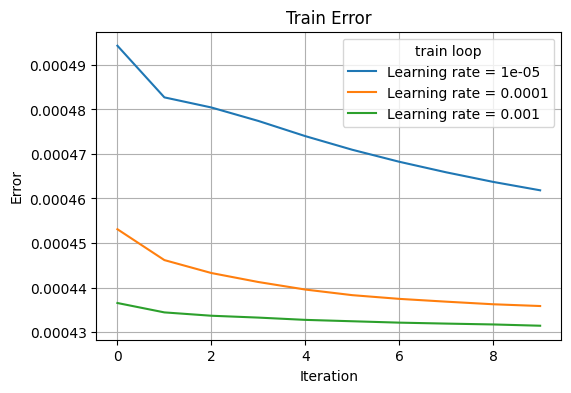

In [74]:
output_size=1
p=128*2
model1=fCNN(X_train.shape[1],p,output_size)
model = model1.to(device)
l= torch.nn.BCEWithLogitsLoss()
epochs=10
learning_rate = np.logspace(-5,-3, 3)
plt.figure(figsize=(6, 4))
for lr in learning_rate:
    print(lr)
    x=train_loop(X_train, epochs, lr, model, l, y_train)[0]
    plt.plot(np.arange(0,epochs,1),x, label=f'Learning rate = {lr}')
    print("final error", x[epochs-1])
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Train Error')
plt.grid(True)
plt.legend(loc='upper right', title='train loop', fontsize='medium')
plt.show()

In [75]:
def test_loop(X_test,y_test, l, model):
    y_test[y_test == -1] = 0
    pred_test=[]
    batch_size = BATCH_SIZE
    test_loss=0
    model.eval()
    threshold = 0.5
    with torch.no_grad():
        # loop over all test input-output pairs
        permutation = torch.randperm(X_test.size()[0])
        for i in range(0, X_test.size()[0], batch_size):
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = X_test[indices], y_test[indices]
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            pred_test.append(outputs)
            loss = l(outputs, batch_y)
            sigmoid_outputs = torch.sigmoid(outputs)
            binary_predictions = (outputs >= 0.5).float()
            test_loss += loss.item()
        test_loss=test_loss/batch_size
    return test_loss, pred_test, binary_predictions

test_loss, y_pred, binary_predictions =test_loop(X_test, y_test.view(-1), l, model)
outputs = model(X_test)
binary_predictions = (outputs >= 0.5).int()
print(binary_predictions)
f1_sc = f1_score(y_test.cpu().view(-1), binary_predictions.cpu(), average='micro')
print(f1_sc)

def test_loop_final(X_test, model):
    pred_test=[]
    batch_size = BATCH_SIZE
    test_loss=0
    model.eval()
    with torch.no_grad():
      # loop over all test input-output pairs
        permutation = torch.randperm(X_test.size()[0])
        for i in range(0, X_train.size()[0], batch_size):
            if i%1000 == 0:
                print(f"Tweet {i}")
            indices = permutation[i:i+batch_size]
            batch_x = X_test[indices]
            outputs = model(batch_x)
            pred_test.append(outputs)
    return pred_test

y_pred_final =  test_loop_final(X_T, model)


tensor([1, 1, 1,  ..., 1, 0, 0], device='cuda:0', dtype=torch.int32)
0.7479293333333333
Tweet 0
Tweet 50000
Tweet 100000
Tweet 150000
Tweet 200000
Tweet 250000
Tweet 300000
Tweet 350000
Tweet 400000
Tweet 450000
Tweet 500000
Tweet 550000
Tweet 600000
Tweet 650000
Tweet 700000
Tweet 750000
Tweet 800000
Tweet 850000
Tweet 900000
Tweet 950000
Tweet 1000000
Tweet 1050000
Tweet 1100000
Tweet 1150000
Tweet 1200000
Tweet 1250000
Tweet 1300000
Tweet 1350000
Tweet 1400000
Tweet 1450000
Tweet 1500000
Tweet 1550000
Tweet 1600000
Tweet 1650000
Tweet 1700000


In [76]:
f1_sc

0.7479293333333333

In [78]:
PREDICTION_FILENAME = PREFIX+"/predictions.csv"
def make_predictions(X_T, model, filename):
    if os.path.exists(filename):
        raise Exception(f"{filename} already exist, comment this line or provide a new filename")
    model.eval()
    with torch.no_grad():
        outputs = model(X_T)
        preds = (outputs >= 0.5).int().cpu()
        print("preds", {preds})
    df = pd.DataFrame({"Id": np.arange(1, preds.shape[0]+1), "Prediction": preds})

    df["Prediction"] = df["Prediction"].map({0:-1, 1:1}).astype(int)
    print(df)
    print(f"Saving to {filename}...")
    df.to_csv(filename, index=False)
make_predictions(X_T, model, PREDICTION_FILENAME)

preds {tensor([0, 0, 0,  ..., 0, 1, 0], dtype=torch.int32)}
         Id  Prediction
0         1          -1
1         2          -1
2         3          -1
3         4           1
4         5          -1
...     ...         ...
9995   9996           1
9996   9997          -1
9997   9998          -1
9998   9999           1
9999  10000          -1

[10000 rows x 2 columns]
Saving to /content/drive/MyDrive/trains//predictions.csv...
